<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [0]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [0]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [16]:
if os.path.isfile('data/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('data/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")
    

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


In [0]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [0]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)

df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)



In [32]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d'],
      dtype='object')

In [0]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [0]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9063252121775113 test Score 0.8745605278006858
Estimators =  50 Train Score 0.9205725512208812 test Score 0.9125653355634538
Estimators =  100 Train Score 0.9238690848446947 test Score 0.9141199714153599
Estimators =  250 Train Score 0.9239789348046863 test Score 0.9188007232664732
Estimators =  450 Train Score 0.9237190618658074 test Score 0.9161507685828595


Text(0.5,1,'Estimators vs score at depth of 5')

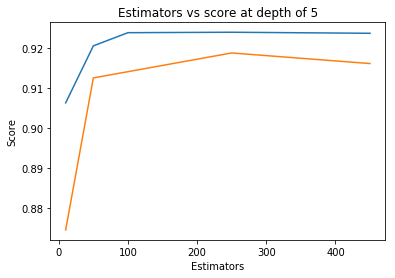

In [0]:
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.8916120853581238 test Score 0.8687934859875491
depth =  9 Train Score 0.9572226298198419 test Score 0.9222953031452904
depth =  11 Train Score 0.9623451340902863 test Score 0.9252318758281279
depth =  15 Train Score 0.9634267621927706 test Score 0.9231288356496615
depth =  20 Train Score 0.9631629153051491 test Score 0.9235051024711141
depth =  35 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  50 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  70 Train Score 0.9634333127085721 test Score 0.9235601652753184
depth =  130 Train Score 0.9634333127085721 test Score 0.9235601652753184


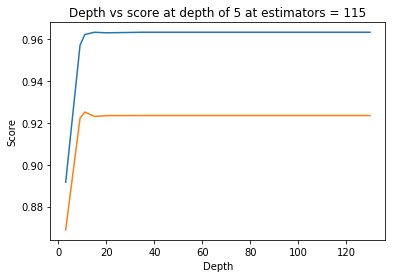

In [0]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

In [0]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = RandomForestClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.96225043 0.96215493 0.96057081 0.96194015 0.96330005]
mean train scores [0.96294922 0.96266735 0.96115674 0.96263457 0.96430539]


In [0]:
print(rf_random.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)


In [0]:
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=14, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=28, min_samples_split=111,
            min_weight_fraction_leaf=0.0, n_estimators=121, n_jobs=-1,
            oob_score=False, random_state=25, verbose=0, warm_start=False)

In [0]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [0]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9652533106548414
Test f1 score 0.9241678239279553


In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


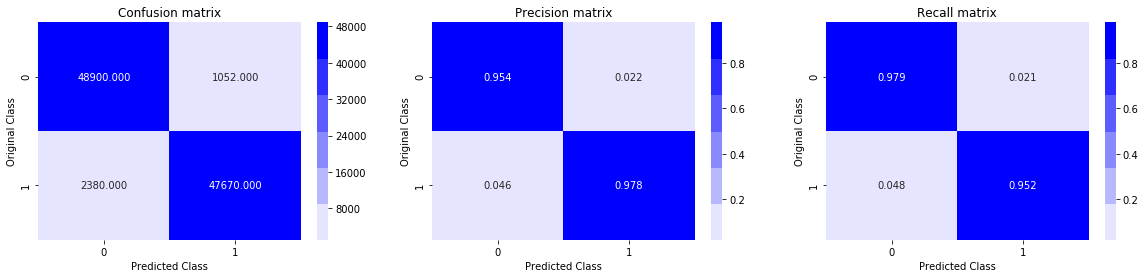

Test confusion_matrix


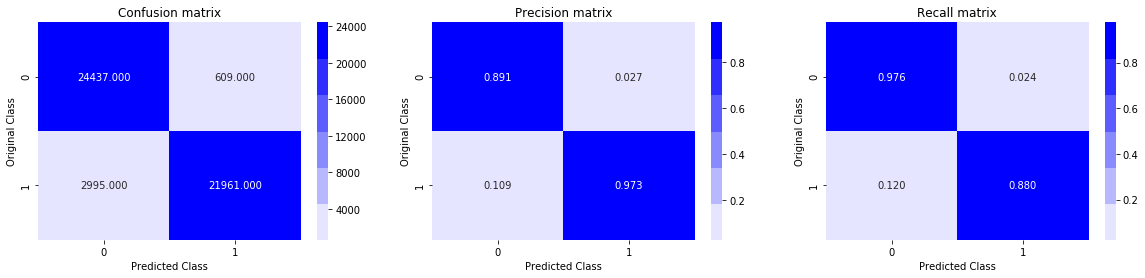

In [0]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

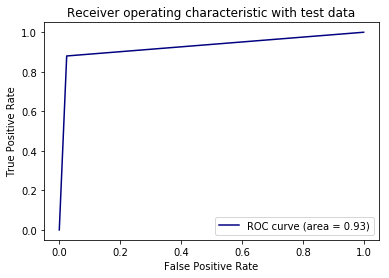

In [0]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

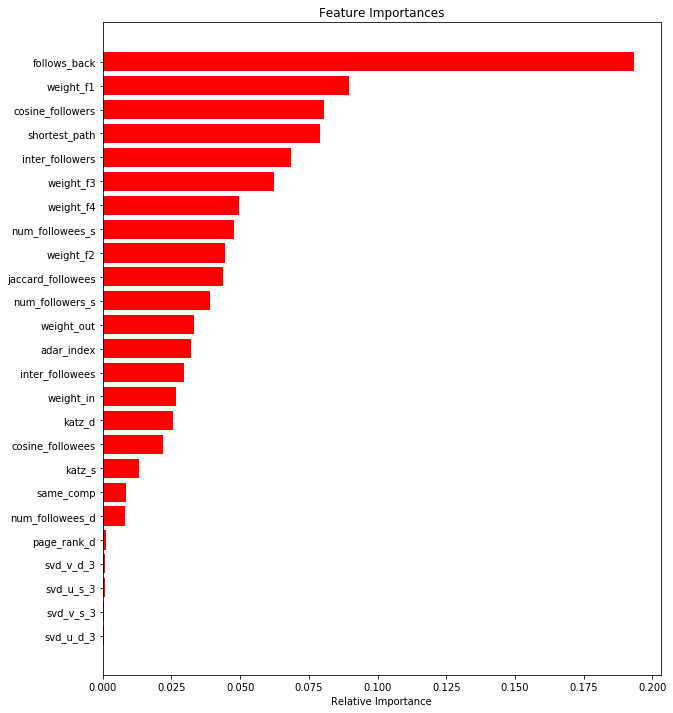

In [0]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

## 1.Preferential Attachment##

One well-known concept in social networks is that users with many friends tend to create more connections in the future. This is due to the fact that in some social networks, like in finance, the rich get richer. We estimate how ”rich” our two vertices are by calculating the multiplication between the number of friends (|Γ(x)|) or followers each vertex has. It may be noted that the similarity index does not require any node neighbor information; therefore, this similarity index has the lowest computational complexity.

In [0]:
df_final_train['preferential_attachment'] = df_final_train.apply(lambda row:np.dot(row['num_followers_s'],row['num_followers_d']),axis=1)
df_final_test['preferential_attachment'] = df_final_test.apply(lambda row:np.dot(row['num_followers_s'],row['num_followers_d']),axis=1)


In [42]:
df_final_test.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'preferential_attachment'],
      dtype='object')

In [43]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'num_followers_d', 'preferential_attachment'],
      dtype='object')

## 2. SVD_dot feature ##

In [0]:
df_final_train['svd_dot_u']=df_final_train.apply(lambda row:np.dot(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']],\
                                    row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]),axis=1)
df_final_train['svd_dot_v']=df_final_train.apply(lambda row:np.dot(row[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],\
                                      row[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]),axis=1)
df_final_test['svd_dot_u']=df_final_test.apply(lambda row:np.dot(row[['svd_u_s_1', 'svd_u_s_2','svd_u_s_3', 'svd_u_s_4', 'svd_u_s_5', 'svd_u_s_6']],\
                                      row[['svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3', 'svd_u_d_4', 'svd_u_d_5','svd_u_d_6']]),axis=1)
df_final_test['svd_dot_v']=df_final_test.apply(lambda row:np.dot(row[['svd_v_s_1','svd_v_s_2', 'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6']],\
                                      row[['svd_v_d_1', 'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5','svd_v_d_6']]),axis=1)

## 3. Tune hyperparameters for XG boost with all these features and check the error metric.##

In [60]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "learning_rate":[0.1,0.2,0.3]}

clf = XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=3,scoring='f1',random_state=25,return_train_score =True)

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98003139 0.98065847 0.98125741 0.98032557 0.98089885]
mean train scores [0.99939519 1.         0.999995   1.         1.        ]


In [61]:
rf_random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=109, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=25,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
df_final_test = df_final_test[df_final_train.columns]

In [63]:
from sklearn.metrics import f1_score

clf = XGBClassifier(n_estimators=109,max_depth=10,learning_rate=0.2,random_state=25,n_jobs=-1)
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)


print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9998001598721024
Test f1 score 0.9258708581138487


Train confusion_matrix


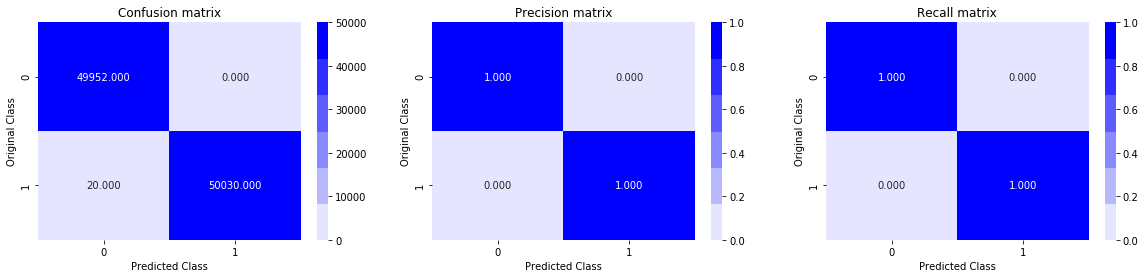

Test confusion_matrix


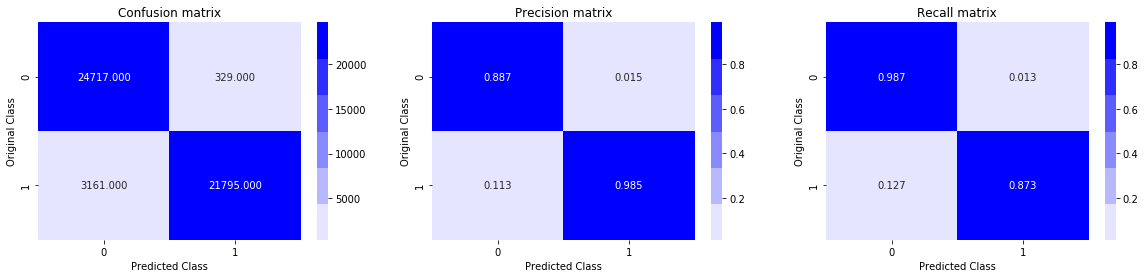

In [66]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

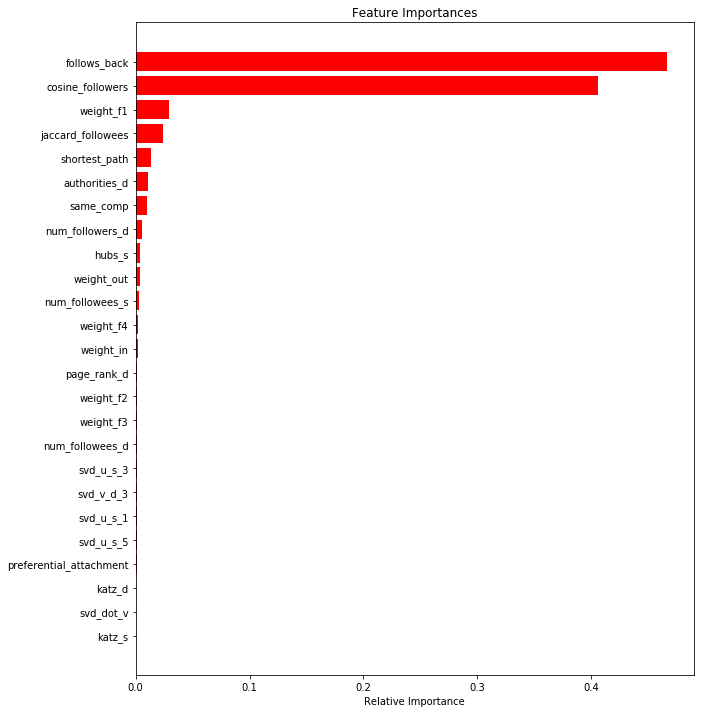

In [67]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [68]:
import pandas as pd
df = pd.DataFrame({'model':['Before adding features','After adding featues'],
             'f1 score(train)':[0.9652533106548414,  0.9998001598721024],
             'f1 score(test)':[0.9241678239279553,  0.9258708581138487]})
df.sort_values(by='f1 score(test)')

,model,f1 score(train),f1 score(test)
0,Before adding features,0.965253,0.924168
1,After adding featues,0.999800,0.925871


*  Here after adding above Preferential Attachment and svd_dot features the f1 score value for train and test is 0.9998001598721024 and 0.9258708581138487.
* Here the difference of train and test score is much higher than before adding the features.
* The feature importance plot shows that the newly added features are not so usefull.